In [4]:
import os
import sys

import pandas as pd
import numpy as np
import random
import itertools

from matplotlib import pyplot as plt

from tqdm import tqdm

from pandarallel import pandarallel

import pymorphy2
import nltk
import pickle
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

import gensim
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.phrases import Phrases, Phraser

import time


SEED = 1
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
init_random_seed(SEED)
    
pd.set_option('display.max_colwidth', 255)
tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=8, use_memory_fs=False)


sys.path.append("..")
from src.torch_trainer import *

%load_ext autoreload
%autoreload 2

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
abbr = pd.read_csv("../data/abbr.csv")
abbr_original = pd.read_csv("../input/abbr_dict.csv", sep="\t")
lenta_train = pd.read_csv("../data/lenta_train.csv")
lenta_test = pd.read_csv("../data/lenta_test.csv")

In [6]:
abbr_pos = abbr_original["abbr"].to_list()
labels = [1] * len(abbr_pos)

desc_norm_list = abbr_original["desc"].to_list()
abbr_neg = []
for desc in desc_norm_list:
    abbr_neg.extend(desc.split(" "))

texts = lenta_train["text"].to_list()
random.shuffle(texts)
for text in tqdm(texts[:len(abbr_neg) * 4]):
    words = text.split(" ")
    random.shuffle(words)
    abbr_neg.extend(words[:1])
labels.extend([0] * len(abbr_neg))

abbr_data = abbr_pos + abbr_neg
len(abbr_data), np.array(labels).mean()

100%|██████████| 548700/548700 [00:13<00:00, 39872.65it/s]


(940954, 0.09090242456060552)

In [7]:
def tokenize(word, max_size):
    tokens = list(map(lambda x: token2id.get(x, 0), list(word)))
    tokens = tokens[:max_size] + [PAD_TOKEN_ID] * (max_size - len(tokens))
    return tokens



def get_tokenized_data(data, data_labels, max_size):
    n = len(data_labels)
    tokenized = torch.zeros((n, max_size)).long()
    labels = torch.zeros(n).long()
    for i in tqdm(range(n)):
        word = data[i]
        for j in range(len(word)):
            tokenized[i][j] = token2id.get(word[j], 0)
        labels[i] = data_labels[i]
    return TensorDataset(tokenized, labels)
#     return torch.Tensor(np.array(tokenized)).long()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(abbr_data, labels, shuffle=True, test_size=0.2)

PAD_TOKEN = "<PAD>"
PAD_TOKEN_ID = 0
UNIQUE_TOKENS = [PAD_TOKEN] + list(set("".join(X_train)))
tokens_num = len(UNIQUE_TOKENS)

token2id = {label: i for i, label in enumerate(UNIQUE_TOKENS)}
id2token = {i: label for label, i in token2id.items()}

def get_max_size(data):
    max_size = 0
    for word in data:
        max_size = max(len(word), max_size)
    return max_size
max_size = get_max_size(abbr_data)

train = get_tokenized_data(X_train, y_train, max_size)
test = get_tokenized_data(X_test, y_test, max_size)

100%|██████████| 188191/188191 [00:02<00:00, 64300.58it/s]


In [9]:
class StackedConv1d(nn.Module):
    def __init__(self, features_num, layers_n=1, kernel_size=3, dropout=0.0):
        super().__init__()
        layers = []
        for _ in range(layers_n):
            conv_block = nn.Sequential(
                nn.Conv1d(
                    features_num, 
                    features_num, 
                    kernel_size, 
                    padding=kernel_size//2 
                ),
                nn.Dropout(dropout),
                nn.LeakyReLU()
            )
            layers.append(conv_block)
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        """x - BatchSize x FeaturesNum x SequenceLen"""
        for layer in self.layers:
            x = x + layer(x) 
        return x

class AbbrDetection(nn.Module): 
    def __init__(self, tokens_num, labels_num, embedding_size=64, layers_n=3, kernel_size=3, dropout=0.1):
        super().__init__()
        self.embeddings = nn.Embedding(tokens_num, embedding_size, padding_idx=0)
        
        self.backbone = StackedConv1d(embedding_size, layers_n=3, kernel_size=3, dropout=0.1)
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.out = nn.Linear(embedding_size, labels_num)
        self.labels_num = labels_num
    
    def forward(self, tokens):
        """tokens - BatchSize x MaxSentenceLen x MaxTokenLen"""
        batch_size, max_sent_len = tokens.shape

        char_embeddings = self.embeddings(tokens)  # BatchSize x MaxSentenceLen x EmbSize
        char_embeddings = char_embeddings.permute(0, 2, 1)
        
        features = self.backbone(char_embeddings) # BatchSize x EmbSize x MaxTokenLen
        global_features = self.global_pooling(features).squeeze(-1)
        
        logits = self.out(global_features)
        
        return logits

In [10]:
model         = AbbrDetection(tokens_num=tokens_num, 
                               labels_num=2, 
                               embedding_size=16, 
                               layers_n=4,
                               kernel_size=3,
                               dropout=0.2)
loss_function = F.cross_entropy
optimizer     = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
def get_f1_score(pred, true):
    pred = pred.argmax(1).cpu().detach().numpy().reshape(-1)
    true = true.cpu().detach().numpy().reshape(-1)
    return f1_score(true, pred, average="macro")

In [118]:
metrics = {
    "macro_f1": get_f1_score,
    "macro_f1_copy": get_f1_score
}

In [119]:
train.tensors[0].dtype

torch.int64

In [126]:
batch_size = 128
learner = PytorchLearner(model, loss_function, train, test, batch_size=batch_size, metrics=metrics)

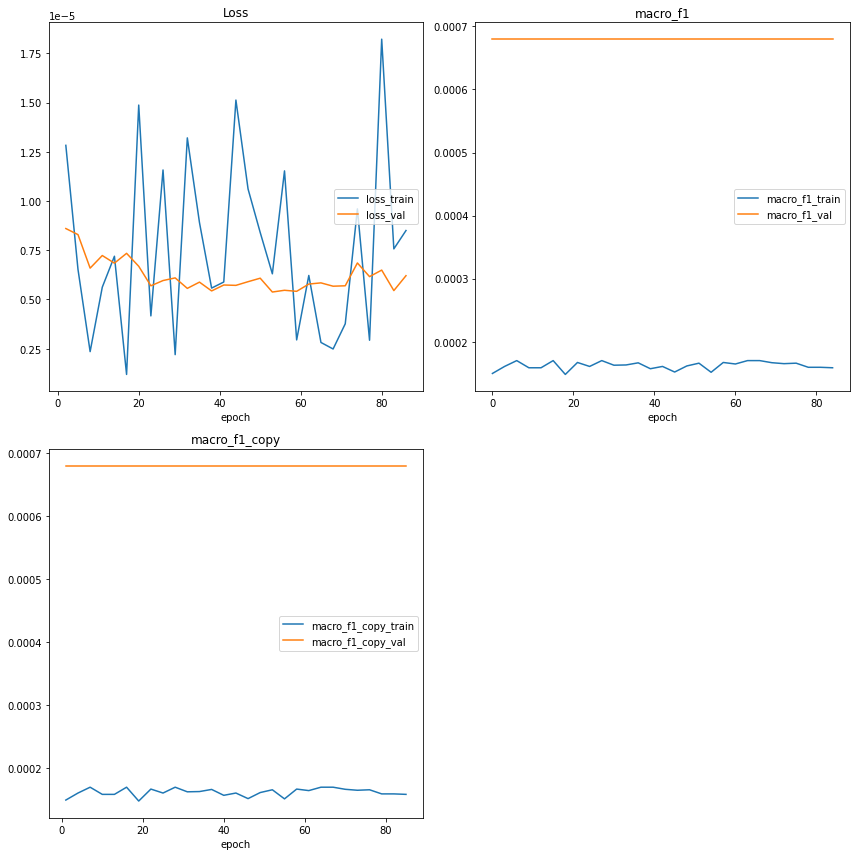

Loss
	loss_train       	 (min:    0.000, max:    0.000, cur:    0.000)
	loss_val         	 (min:    0.000, max:    0.000, cur:    0.000)
macro_f1
	macro_f1_train   	 (min:    0.000, max:    0.000, cur:    0.000)
	macro_f1_val     	 (min:    0.001, max:    0.001, cur:    0.001)
macro_f1_copy
	macro_f1_copy_train 	 (min:    0.000, max:    0.000, cur:    0.000)
	macro_f1_copy_val 	 (min:    0.001, max:    0.001, cur:    0.001)
Модель не улучшилась за последние 10 эпох, прекращаем обучение


In [127]:
learner.fit(100)

In [17]:
torch.save(model.state_dict(), "../data/abbr_detection_model.model")

In [130]:
model = learner.best_model

tensor([123,  36, 146, 180, 115, 153, 165, 185, 115, 166,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0])

In [141]:
model(test.tensors[0].to(learner.device))

RuntimeError: CUDA out of memory. Tried to allocate 576.00 MiB (GPU 0; 9.78 GiB total capacity; 6.71 GiB already allocated; 299.25 MiB free; 6.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [142]:
model = model.to("cpu")

In [145]:
torch.Tensor([tokenize("чтд", max_size=max_size)]).long().to(device)

tensor([[188,  17,  50,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0]], device='cuda:0')

In [ ]:
model()

In [148]:
def is_abbr(word):
    return model(
        torch.Tensor([tokenize(word, max_size=max_size)]).long().to("cpu")
    ).argmax(1).tolist()[0] == 1

In [154]:
is_abbr("РФ")

False

In [159]:
for X, y in zip(X_test, y_test):
    pred = is_abbr(X)
    if bool(y) != pred:
        print(X, bool(y), pred)

эск True False
Энергомодель True False
Электротяжмаш True False
Импорт False True
тдн True False
угрозыск True False
индпошив True False
штабартдив True False
автобензин True False
Кировск. False True
фармпредприятие True False
рр True False
камерн. True False
дел. False True
театр. True False
соцвыплата True False
планфинотдел True False
НИИ False True
авиапочта True False
терслужба True False
линал True False
ОРГРЭС False True
зато True False
ВОЗ False True
СО True False
надсмотр. False True
бронетранспортёр True False
мд True False
псих. True False
агробаза True False
ВМС True False
молкомбинат True False
стройэкология True False
АК&М True False
несов. True False
Укркабель True False
РАО True False
бух. True False
Сигналсвязьзаводы True False
МПР False True
НТВ False True
РАО True False
Лента True False
УК False True
ДНК-анализ False True
Джобс False True
грузоперевозчик True False
ОП False True
РГ False True
А False True
АН False True
телесценарист True False
мр True False
монт. Tr

полком True False
европолитик True False
дорр True False
дабл-дабл False True
Дальгиз True False
Арнест True False
Сортсемовощ True False
автомотоклуб False True
КНЦ False True
РТС False True
Уралосновхим True False
МОК False True
горстанция True False
Донбассцемент True False
м True False
кн-во True False
начдив True False
физфак True False
СО True False
гразер True False
тензометр False True
райводоканал True False
нижненем. True False
геофиз. True False
автолобби True False
ТВ False True
зооферма True False
Джибриль False True
ФАС False True
ФОМа False True
Ульяновск. False True
Фанта-Спрайт-Кола False True
Р True False
госфинансирование True False
ФПС False True
АФК False True
ВТБ False True
Дружковка False True
Центробанком False True
ОИГГиМ False True
наркопосев True False
Помпедун True False
ФРГ False True
Е.П. True False
рад. True False
Шипп. False True
авиагарнизон True False
ЛБФ False True
атто... False True
лин-ка True False
евр True False
Арктикцентр True False
дл True Fals

РГГУ False True
ГЛТУ False True
Роскомметаллургия True False
автоперегрузчик True False
СНГ False True
телепередатчик True False
РЖД False True
Ир False True
НБП False True
оаэ True False
худграф True False
СБУ False True
ГДР-овском False True
гол. True False
теледебаты True False
тележурналистика True False
КНДР False True
ЗАОр True False
виброгаситель True False
зем. True False
психтюрьма True False
комфронт True False
Этап False True
Стален True False
О. True False
артвзвод True False
ГУМе False True
Счётпалата True False
О True False
Росювелирторг True False
АСВ False True
СК False True
муляж. False True
нардеп True False
током. False True
динамсар True False
фэсэошник True False
предик. True False
политкаторжанин True False
драмтеатр True False
Искождеталь True False
Проектэкскаватор True False
Электроприбор True False
Пер True False
взрывснаряд True False
клк True False
Текстильтрест True False
ВАСХНИЛ False True
Ворошиловградпроходка True False
МИАН False True
байнет True False


генкомпания True False
ЮНЕСКО False True
живсырье True False
а True False
КР False True
чайн. True False
травм. False True
Зах. True False
МЭА False True
СиЧ True False
ГМК False True
медкарта True False
Хирбат False True
замобо True False
ямпи True False
искосол True False
ЧАССР True False
адхозотдел True False
А False True
СССР True False
шок True False
велокросс True False
бортмеханик. False True
проф. False True
земпай True False
ГАСИС False True
ХХ False True
Электропровод True False
Ер True False
Интелсист True False
МКС False True
А False True
СМИД True False
комсод True False
бррка True False
бензонасос True False
абон True False
ИД False True
Югосталь True False
СИЗО False True
госзаказ False True
госструктур False True
Р True False
Винун True False
кварт. True False
избытком False True
пожр True False
раэ True False
завкадрами True False
УК False True
ФИАН False True
Уралметаллотрест True False
инфосфера True False
ЛНР False True
СФ False True
Донецк. False True
госплемрассад

райсовет True False
ЦБ True False
СНГ False True
телепублицистика True False
спецматериал True False
кон. True False
ЦКТИ False True
НИИфизики True False
метстанция True False
райфинуправление True False
Днепроспецсталь False True
нек-рая True False
минд True False
терком True False
Р True False
горсеть True False
РТС False True
естеств. True False
сельсовет True False
форниз True False
МТС False True
ДТП True False
радио True False
Р True False
нейтр. True False
ВСНХ False True
ВБД False True
ФАС False True
эффект. False True
час. True False
Туймазнефть True False
Русьуниверсалбанк True False
автосалон True False
авиастанция True False
ил(л). True False
спецкомиссия True False
Томусашахтострой True False
Камгэсэнергострой False True
априм-м True False
ларингоскоп False True
кило True False
госфинансы True False
почтит. True False
гидростанция True False
Никол. True False
демдвижение True False
КИУ False True
СевероморскСтрой False True
ГАИ False True
рек True False
избытком False True

НАСА False True
КНДР False True
ГАИ False True
ВМС True False
АН False True
Донбассантрацит True False
Донн. False True
Эл False True
теплонасос True False
ФСР True False
ЖК-дисплеем False True
столов True False
взаимозачёт True False
ОИ False True
авиабензин True False
неофиц. True False
трост. True False
старлей True False
демонтаж False True
спецвагон True False
трудком True False
Россвязь True False
дымомаскировка True False
штрафстоянка True False
см. False True
сантех. True False
РЭА False True
Нижагрофонд True False
сталагмит False True
Свердловскуголь True False
Промак True False
неизм. True False
межрег. True False
ВВС True False
Р True False
культкомбинат True False
ОНЦ True False
пролет. True False
ФССП False True
металлоремонт True False
ФРС False True
аппарат. False True
ЛДПР True False
Мал. True False
рем True False
КХЛ False True
Живконтора True False
РАСС True False
спортинвентарь True False
Харнитол True False


In [158]:
X_test

['грузинских',
 'крупнейших',
 'В',
 'корабля.',
 'компьютерной',
 'подробную',
 'здании',
 'переформировали',
 'Медведевой,',
 'однако',
 'дизайнерского',
 'лазарет',
 '25',
 'иракской',
 'действия',
 'повышения',
 'По',
 'недостаточная',
 'управления',
 'что',
 'противовоздушной',
 'промышленных',
 'институт',
 'и',
 'части',
 'АХБ',
 'предложение',
 'тракторного',
 'аппаратов',
 'населения',
 'командира',
 'обучения',
 'также',
 'триллиона',
 '15',
 'Оставшиеся',
 'великомученицы',
 'связь',
 'эск',
 'Генеральный',
 'унылого',
 'сигнализатор',
 'центр',
 'службу',
 'Пермская',
 'помощь',
 'вспоминает',
 'АЭС',
 'электроагрег',
 'работает',
 'кран',
 '16',
 'также',
 'в',
 'заведующий',
 'комбината',
 'субботы',
 '"Новости",',
 'года',
 'ФМС.',
 'монополиях,',
 'ФБДД УГИБДД МВД РТ',
 'инвалидов',
 'газеты"',
 'общин',
 'января',
 'пробег',
 'Турнир',
 'РЛ',
 'общественных',
 'совет',
 'незаконного',
 'террористические',
 'тяжёлая',
 'Марр',
 'Доминики',
 'почта',
 'службы',
 'человек